In [2]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# The data has the following structure: 
# recorded for each user who has made purchases, each day there is a different folder for each date,
# inside it are folders for each user inside each folder there is a data.csv file where the data is stored
# Schematically it looks like this:
# └── data
#    ├── 2020-12-30
#    │  ├── FirstName_LastName1
#    │  │   └── data.csv
#    │  ├── FirstName_LastName2
#    │  │   └── data.csv
#    │  └── FirstName_LastName3
#    │      └── data.csv
#    └── 2020-12-31
#       ├── FirstName_LastName1
#       │   └── data.csv
#       └── FirstName_LastName5
#           └── data.csv

In [4]:
# 4.1 TASK
# Collect all data from the data folder into one dataframe with the following columns: 
# columns from the files themselves (product_id, quantity) as well as the user name (name), 
# and the date of these purchases (date corresponds to the name of the folder where the user folder lies)

In [5]:
sells_by_date = pd.DataFrame({'date':[], 'name':[], 'product_id':[], 'quantity':[]})

In [6]:
for csv_path in Path('./data').glob("**/*.csv"):           # cycle go over all csv files in "data" folder
    full_path_of_small_df = Path(Path.cwd(), csv_path)     # create full path for a csv file
    small_df = pd.read_csv(str(full_path_of_small_df))     # read the csv file
    small_df = small_df[['product_id', 'quantity']]        # remove unnecessary column "Unnamed: 0"
    
    path_in_string = str(csv_path)                         # transmute "windows Path" object to string
    path_in_list = path_in_string.split('\\')              # split path to list of folder names
    
    small_df['date'] = path_in_list[1]                     # path_in_list[1] contain date of sell. We can create and fill column 'date'
    small_df['name'] = path_in_list[2]                     # path_in_list[2] contain name of buyer. We can create and fill column 'name'
    
    sells_by_date = pd.concat([sells_by_date, small_df], ignore_index=True)  # add data from csv file to global dataframe

sells_by_date['date'] = pd.to_datetime(sells_by_date['date'])  # specify 'date' column as containing datetime object

sells_by_date

,date,name,product_id,quantity
0,2020-12-03,Alexey_Smirnov,47.0,1.0
1,2020-12-03,Alexey_Smirnov,57.0,1.0
2,2020-12-03,Alexey_Smirnov,14.0,2.0
3,2020-12-03,Alexey_Smirnov,52.0,1.0
4,2020-12-03,Alexey_Smirnov,1.0,4.0
...,...,...,...,...
156,2020-12-09,Rostislav_Petrov,66.0,4.0
157,2020-12-09,Rostislav_Petrov,39.0,2.0
158,2020-12-09,Vasiliy_Ivanov,82.0,4.0
159,2020-12-09,Vasiliy_Ivanov,74.0,2.0


In [7]:
# 4.2 Task: enter the amount in the quantity column

(
  sells_by_date
    .aggregate({'quantity' : 'sum'})
)

# Answer - 480

quantity    480.0
dtype: float64

In [8]:
# 4.3 Task: Find out which user bought the most items. If there is more than one,
# list the names separated by a comma with a space and in alphabetical order

(
  sells_by_date
    .groupby('name', as_index = False)
    .aggregate({'quantity' : 'sum'})
    .sort_values('quantity', ascending = False)
    .head()
)

# Answer - Alexey_Smirnov and Petr_Smirnov

,name,quantity
3,Alexey_Smirnov,52.0
13,Petr_Smirnov,52.0
6,Anton_Smirnov,45.0
10,Petr_Fedorov,34.0
7,Kirill_Fedorov,28.0


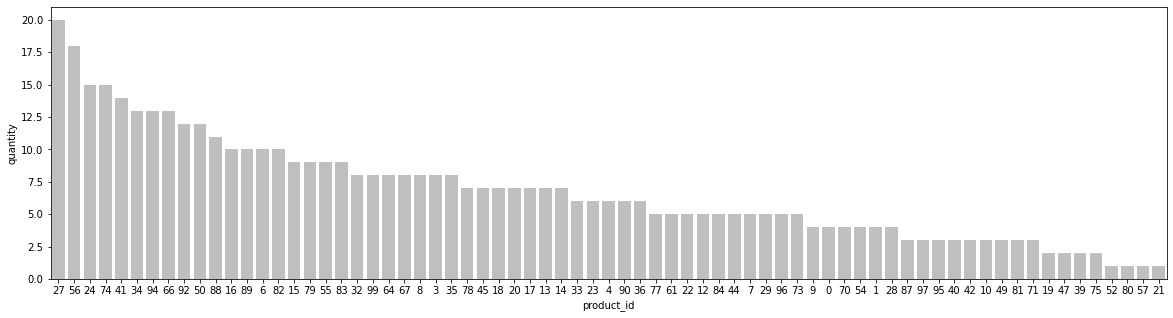

In [9]:
# 4.4 Task: Find the top 10 products by number of units sold over time and build a barplot (bar chart, sns.barplot), where:

# on the x-axis are the product identifiers (product_id) 
# on the y-axis is the total number of their purchases (how many items with that product_id were sold)
# For practice try to change graph parameters: colour (color), transparency (alpha), sorting of values on x-axis (order). 

# The answer is how many units of product with product_id equal to 56 were sold.

sells_by_date = sells_by_date.astype({'product_id' : 'int', 'quantity' : 'int'})  # original object type float make .0 on plot

how_many_products = (sells_by_date                            # create a new dataframe with the total amount of each item sold
                    .groupby('product_id', as_index = False)
                    .aggregate({'quantity' : 'sum'})
                    )

plt.figure(figsize=(20, 5))

(
    sns.barplot(
        x = 'product_id',
        y = 'quantity',
        data = how_many_products,
        color = 'grey',
        alpha = 0.5,
        order = how_many_products.sort_values('quantity', ascending = False).product_id)
)

plt.show()

In [10]:
# 4.5 Let's look at sales by day! Use barplot again for visualisation,
# but now on the x-axis will be the days for which we have data.

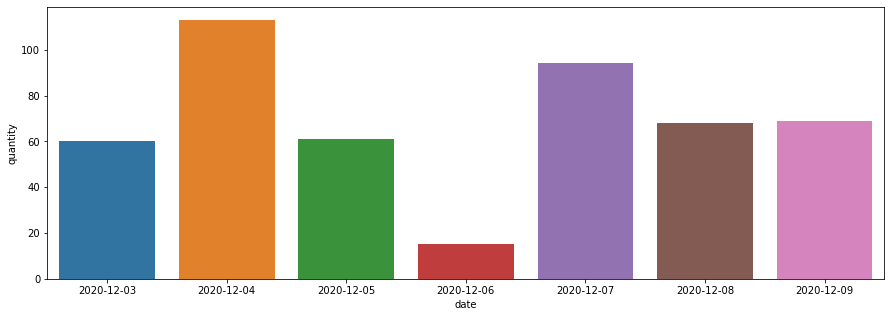

In [11]:
products_by_days = (sells_by_date                            # create a new dataframe with the total sells by each day
                    .groupby('date', as_index = False)
                    .aggregate({'quantity' : 'sum'})
                    .astype({'date' : 'string'})
                    )

sells_by_date = sells_by_date.astype({'product_id' : 'int', 'quantity' : 'int'})  # original object type float make .0 on plot

plt.figure(figsize=(15, 5))

(
    sns.barplot(
        x = 'date',
        y = 'quantity',
        data = products_by_days)
)

plt.show()

In [27]:
# 4.6 How many users have purchased any product repeatedly (more than once)?
# A repeat purchase is a purchase of an item with the same product_id made on different days. 

# For example, user Sasha Tsarev bought item 6 twice. Since the purchase was made on the same day,
# it will not be counted as repeated in this case. Katya Skriptsova also made two purchases of product 7,
# but on different days, so this case counts.

(
 sells_by_date
 .groupby(['name', 'product_id'], as_index = False)
 .agg({'date' : pd.Series.nunique})                   # counting the number of days a person has bought an product
 .rename(columns = {'date' : 'shopping_days_number'})
 .query("shopping_days_number != 1")
)

# Answer - 2

,name,product_id,shopping_days_number
37,Anton_Ivanov,15,2
92,Petr_Fedorov,94,2
